In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from oodles import Framework, monitor, Anomaly, DataDriftAlgo, AbstractAnomaly

In [2]:
#Read the training and test set
df = pd.read_csv("data/NSL-KDD/binary_train_test.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.1, 
                                                    test_size = 0.9, 
                                                    random_state = 0,
                                                    shuffle=False)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     69135
           1       0.99      0.93      0.96     64531

    accuracy                           0.96    133666
   macro avg       0.97      0.96      0.96    133666
weighted avg       0.96      0.96      0.96    133666

Accuracy: 0.9622417069411817


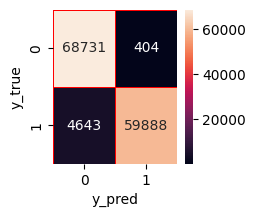

In [4]:
# Xgboost algorithm
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(2,2))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Define a Custom Drift Monitor

In [5]:
class CustomConceptDrift(AbstractAnomaly):
    """
    Defining a custom drift metric where
    the user just want to check if accuracy 
    drops beyond a threshold.
    """
    def __init__(self): 
        self.initial_acc = None       
        self.acc_arr = []
        self.count = 0       
        self.thres = 0.02
        self.window_size = 200
        self.is_drift_detected = False
        
    def check(self, inputs, outputs, gts=None, extra_args={}):
        self.count += 1
        self.acc_arr.append(outputs[0]==gts[0])
        if self.count == self.window_size:
            self.initial_acc = sum(self.acc_arr)/self.window_size
        if (self.initial_acc is not None) and (not self.is_drift_detected):
            recent_acc = sum(self.acc_arr[-self.window_size:])/self.window_size
            if self.initial_acc - recent_acc > self.thres:
                print("Concept drift detected with custom metric at time: ", self.count)
                self.is_drift_detected = True
        
    def is_data_interesting(self, inputs, outputs, gts=None, extra_args={}):
        return False

    def need_ground_truth(self):
        return True

#### Define Prediction Function

In [6]:
inference_batch_size = 256
cfg = {
    # Define your metrics to identify data drifts
    "checks": [
        {
        'type': Anomaly.CONCEPT_DRIFT,
        'algorithm': DataDriftAlgo.DDM,
        'warn_thres': 2,
        'alarm_thres': 3,
        },
        {
        'type': Anomaly.CUSTOM_MONITOR,
        'algorithm': CustomConceptDrift,
        'need_gt': True,
        },
    ], 
    "batch_size": inference_batch_size,
    "training_args": {
        "fold_name": 'oodles_smart_data', 
    }
}
        
framework = Framework(cfg)

@monitor(framework)
def model_predict(args):
    return args['model'].predict(args['X_test'])

Deleting the folder:  oodles_smart_data


#### Check for Data Drift with DDM

In [7]:
y_preds = np.zeros(y_test.shape)
time_pred = []
time_gt = []
for i in range(int(len(X_test)/inference_batch_size)):
    inputs = {'model': classifier, 
              'X_test': X_test[i*inference_batch_size:(i+1)*inference_batch_size]}
    
    y_pred, idens = model_predict(inputs)
    y_preds[i*inference_batch_size:(i+1)*inference_batch_size] = y_pred
    framework.attach_ground_truth({'identifier': idens, 
                                   'gt': y_test[i*inference_batch_size:(i+1)*inference_batch_size]})

    # Retrain only once
    if framework.version > 1:
        break

/Users/vipul/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/oodles-0.1.dev0-py3.10.egg/oodles/core/classes/framework.py:341: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Concept drift detected with custom metric at time:  111156
Drift detected with DDM at time:  111298


#### Plotting observed accuracy with time to check location of drifts

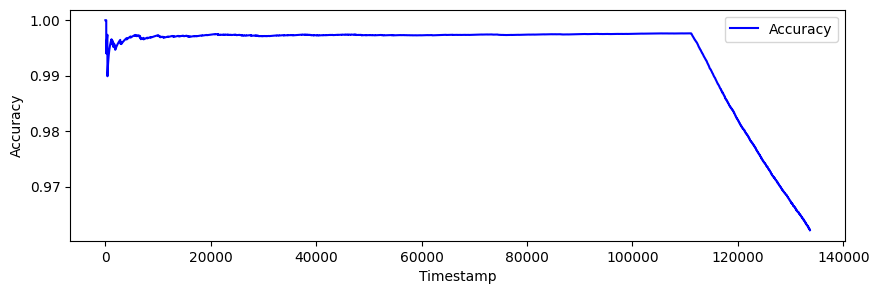

In [8]:
# Define accuracy over time
acc = np.cumsum(y_preds==y_test)/np.arange(1,len(y_preds)+1)

# Plot the accuracy changes
plt.rcParams.update({'font.size': 10})
plt.figure(1,figsize=(10,3)) 
plt.clf() 
plt.plot(acc,'-b',label='Accuracy')

plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')

plt.draw()

From the above plot, we can observe a data drift around the timestamp of 111k, which is also predicted by our drift monitors.